# Proteomic Data Aggregation and Visualization

This notebook demonstrates the aggregation of proteomic data via National Microbiome Data Collaborative (NMDC)'s [Runtime API](https://api.microbiomedata.org/docs). It also provides an example proteomic analysis and a method of connecting the results to other datasets in NMDC. 

Notebook Steps:

1) Assess background information and collect datasets for James Stegen's study on riverbed sediment along the Columbia River

2) Apply a spectral probability filter across the data that optimizes the number of identifications for an FDR of 0.05

3) Collapse to unique peptides and normalize quantification

4) Generate protein mappings using both "Razor" and "Sorted List" strategies

5) Perform protein rollup using the "Sorted List" results and summarize into a final aggregated crosstab

6) Find additional datasets across omics types in NMDC that share relevant KEGG IDs with this study


Import libraries and the python script 'aggregation_functions.py', also located in this folder. 'aggregation_functions.py' contains functions necessary to run this notebook including API traversal, spectral probability filtering and protein mapping. 

In [1]:
import requests
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import nmdc_api as api_func
import aggregation_functions as agg_func

## 1) Assess background information and collect data for James Stegen's study on riverbed sediment along the Columbia River

Review the Stegen study on the [NMDC data portal](https://data.microbiomedata.org/details/study/nmdc:sty-11-aygzgv51). Use the study `id` embedded in the url (nmdc:sty-11-aygzgv51) to collect biosamples via the [NMDC Runtime API](https://api.microbiomedata.org/docs). Determine potential sample groupings using a subset of the comprehensive metadata

In [2]:
Stegen_biosample_info = api_func.get_next_results(collection='biosample_set',\
                       filter='{"associated_studies":"nmdc:sty-11-aygzgv51"}',\
                        max_page_size=100,fields='id,name,lat_lon.has_raw_value,depth.has_numeric_value')

display(pd.json_normalize(Stegen_biosample_info)['name'].str.split('-').str[0].value_counts().to_frame())
display(pd.json_normalize(Stegen_biosample_info)['lat_lon.has_raw_value'].value_counts().to_frame())
display(pd.json_normalize(Stegen_biosample_info)['depth.has_numeric_value'].value_counts().to_frame())

,count
name,
"Groundwater microbial communities from the Columbia River, Washington, USA",35
"Riverbed sediment microbial communities from areas with vegetation nearby in Columbia River, Washington, USA",18
"Sand microcosm microbial communities from a hyporheic zone in Columbia River, Washington, USA",16
"Riverbed sediment microbial communities from areas with no vegetation in Columbia River, Washington, USA",15
"Sand microcosm microbial communities from a hyporheic zone in Columbia River, Washington, USA",1


,count
lat_lon.has_raw_value,
46.372 -119.272,35
46.37228379 -119.2717467,23
46.37379502 -119.2722385,6
46.37228508 -119.2716818,6
46.37380143 -119.2723688,5
46.37229149 -119.2718121,5
46.37380273 -119.2723038,4
46.37228249 -119.2718117,1


,count
depth.has_numeric_value,
0.5,22
0.4,6
0.0,6
0.3,6
0.2,5
0.1,5


The slot `in_manifest` links NMDC data objects that can be analyzed together. Use it to search for the `id` nmdc:manif-11-7796sg87, which will provide proteomic workflow outputs for the Stegen study. In this case, `in_manifest` is linking LC-MS/MS runs that were performed in succession on the same instrument for the same study

In [3]:
proteomic_output=api_func.get_next_results(collection='data_object_set',\
                       filter='{"in_manifest":"nmdc:manif-11-7796sg87"}',\
                        max_page_size=100,fields='')

#how many different output types are there?
pd.DataFrame(proteomic_output)[['data_object_type','description']].value_counts()

data_object_type                    description                                                                
Metaproteomics Workflow Statistics  Overall statistics from MSGF+ search results filtered to ~5% FDR               33
Peptide Report                      Aggregated peptides sequences from MSGF+ search results filtered to ~5% FDR    33
Protein Report                      Aggregated protein lists from MSGF+ search results filtered to ~5% FDR         33
Unfiltered Metaproteomics Results   Aggregation of analysis tools {MSGFplus, MASIC} results                        33
Name: count, dtype: int64

Find the workflows that created these proteomic outputs by mapping `id` on the previous search to `has_output` on the `workflow_execution_set`. Then examine the input file types used for these workflows by mapping `has_input` from the workflow search to `id` in the `data_object_set`

In [4]:
workflow=api_func.get_id_results(newest_results=proteomic_output,\
                                id_field="id",\
                                query_collection="workflow_execution_set",\
                                match_id_field="has_output",\
                                query_fields="has_output,has_input")

inputfiles=api_func.get_id_results(newest_results=workflow,\
                                id_field="has_input",\
                                query_collection="data_object_set",\
                                match_id_field="id",\
                                query_fields="id,data_object_type,url")

pd.DataFrame(inputfiles).drop_duplicates()['data_object_type'].value_counts()

data_object_type
Annotation Amino Acid FASTA    33
Functional Annotation GFF      33
LC-DDA-MS/MS Raw Data          33
Name: count, dtype: int64

Examine the information in data_object_type 'Unfiltered Metaproteomics Results', which contains peptide identifications and abundances, and the information in data_object_type 'Functional Annotation GFF', which contains gene annotations for each protein

In [5]:
pd.set_option("display.max_rows", 6)

#example unfiltered results 
unfilt_results = pd.DataFrame(proteomic_output)[pd.DataFrame(proteomic_output)['data_object_type']=="Unfiltered Metaproteomics Results"].iloc[0]["url"]
print(unfilt_results)

#pull data as TSV using url
for tsv in [unfilt_results]:
    response = requests.get(tsv)
    data = StringIO(response.text)
    df = pd.read_csv(data,sep='\t')
    data.close()
    display(df)
    del response, data, df, tsv

del unfilt_results


https://nmdcdemo.emsl.pnnl.gov/proteomics/results/nmdc_dobj-11-ms76kj12_nmdc_dobj-11-c5av0320_msgfplus_syn_PlusSICStats.txt


,ResultID,Scan,FragMethod,SpecIndex,Charge,PrecursorMZ,DelM,DelM_PPM,MH,Peptide,...,PeakMaxIntensity,PeakSignalToNoiseRatio,FWHMInScans,PeakArea,ParentIonIntensity,ParentIonMZ,StatMomentsArea,PeakScanStart,PeakScanEnd,PeakWidthMinutes
0,1,36947,HCD,1,3,968.47449,-0.00469,-1.61740,2902.410370,K.NYSPYYNTIDDLKDQIVDLTVGNNK.T,...,6619700.0,106.00,62,503970000.0,4468100.0,968.47,453600000.0,36866,37232,0
1,2,30576,HCD,2,3,1017.16516,-0.01640,-5.38151,3048.494105,K.VLYDAEISQIHQSVTDTNVILSMDNSR.N,...,2595300.0,343.30,115,227780000.0,2481100.0,1017.17,206570000.0,30497,30787,0
2,3,21671,HCD,3,3,1050.48071,0.02323,7.38083,3148.400992,K.NADSTLHTVTSGTAEGGESGTVFDSSYMAAGK.T,...,2393100.0,165.90,14,51712000.0,1454200.0,1050.48,53478000.0,21598,21730,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22014,22015,10397,HCD,19177,2,535.74500,-0.00116,-1.08134,1069.480463,K.DMMELFQR.A,...,1673900.0,37.75,213,246200000.0,2129400.0,535.74,230580000.0,10205,10427,0
22015,22016,7224,HCD,19179,3,525.91705,-0.01298,-8.23982,1575.749593,K.VEETEKGEEQLER.L,...,2701400.0,20.38,104,291450000.0,2969100.0,526.25,241570000.0,7097,7395,0
22016,22017,32524,HCD,19178,2,1130.05615,-0.00976,-4.32084,2259.114693,-.SDIPGQDCKMIFGHLDELLK.I,...,736733.0,24.86,59,32040000.0,812098.0,1130.06,27600000.0,32481,32598,0


In [6]:
#example annotation file
input_file=pd.DataFrame(inputfiles)[pd.DataFrame(inputfiles)['data_object_type']=="Functional Annotation GFF"].iloc[0]["url"]
print(input_file)

#pull data as TSV using url
for tsv in [input_file]:
    response = requests.get(tsv)
    data = StringIO(response.text)
    df = pd.read_csv(data,sep='\t',header=None,low_memory=False)
    data.close()
    display(df)
    print(df.iloc[0,8])
    del response, data, df, tsv

del input_file

https://data.microbiomedata.org/data/nmdc:omprc-13-earxpt36/nmdc:wfmgan-11-n8fv8w29.1/nmdc_wfmgan-11-n8fv8w29.1_functional_annotation.gff


,0,1,2,3,4,5,6,7,8
0,nmdc:wfmgan-11-n8fv8w29.1_000001,Prodigal v2.6.3_patched,CDS,1,123,1.1,+,0,ID=nmdc:wfmgan-11-n8fv8w29.1_000001_1_123;tran...
1,nmdc:wfmgan-11-n8fv8w29.1_000001,Prodigal v2.6.3_patched,CDS,441,596,1.0,+,0,ID=nmdc:wfmgan-11-n8fv8w29.1_000001_441_596;tr...
2,nmdc:wfmgan-11-n8fv8w29.1_000001,Prodigal v2.6.3_patched,CDS,621,1382,81.1,-,0,ID=nmdc:wfmgan-11-n8fv8w29.1_000001_621_1382;t...
...,...,...,...,...,...,...,...,...,...
154014,nmdc:wfmgan-11-n8fv8w29.1_127317,GeneMark.hmm-2 v1.25_lic,CDS,3,101,3.17,-,0,ID=nmdc:wfmgan-11-n8fv8w29.1_127317_3_101;tran...
154015,nmdc:wfmgan-11-n8fv8w29.1_127318,Prodigal v2.6.3_patched,CDS,1,198,23.9,-,0,ID=nmdc:wfmgan-11-n8fv8w29.1_127318_1_198;tran...
154016,nmdc:wfmgan-11-n8fv8w29.1_127319,Prodigal v2.6.3_patched,CDS,1,198,7.2,-,0,ID=nmdc:wfmgan-11-n8fv8w29.1_127319_1_198;tran...


ID=nmdc:wfmgan-11-n8fv8w29.1_000001_1_123;translation_table=11;partial=5';start_type=Edge;product=pyruvate-formate lyase-activating enzyme;product_source=COG1180;cog=COG1180


Connect each of the 33 peptide identification files and their corresponding gene annotation files to the 33 biosamples by mapping the raw LC-MS/MS `id`s to the `data_generation_set` that created them via the `has_output` slot. Then map the data generation `has_input` to the biosample `id` collected earlier. Finally, merge all this information into a single dataframe

In [7]:
data_generation=api_func.get_id_results(newest_results=inputfiles,\
                                id_field="id",\
                                query_collection="data_generation_set",\
                                match_id_field="has_output",\
                                query_fields="has_input,has_output,name")

#adjust and rename dataframes for merging
proteomic_output = pd.DataFrame(proteomic_output)[['url','id','data_object_type']].rename(columns={'url':'processed_results_url','data_object_type':'processed_data_object_type','id':'processed_DO_id'})
proteomic_output = proteomic_output[(proteomic_output['processed_data_object_type']=='Unfiltered Metaproteomics Results')].reset_index(drop=True).drop(['processed_data_object_type'],axis=1)
workflow=pd.DataFrame(workflow).explode('has_input').explode('has_output').drop_duplicates().rename(columns={'id':'workflow_id'})
raw_input=pd.DataFrame(inputfiles)[['id']].drop_duplicates()
data_generation = pd.DataFrame(data_generation).explode('has_input').explode('has_output').drop_duplicates().drop('id',axis=1).rename(columns={'name':'data_generation_name'})
Stegen_biosample_info=pd.json_normalize(Stegen_biosample_info).rename(columns={'id':'biosample_id','name':'biosample_name'})

#merge df
proteomics_processing_df = Stegen_biosample_info\
    .merge(data_generation,left_on='biosample_id',right_on='has_input').drop('has_input',axis=1)\
        .merge(raw_input,left_on='has_output',right_on='id').drop(['has_output'],axis=1)\
            .merge(workflow,left_on='id',right_on='has_input').drop(['id','has_input'],axis=1)\
                .merge(proteomic_output,left_on='has_output',right_on='processed_DO_id').drop('has_output',axis=1)


#attach annotation files to the associated workflow so that it can be merged with proteomics_processing_df
annotationfiles = pd.DataFrame(inputfiles).rename(columns={'id':'annotation_id','url':'annotation_url','data_object_type':'annotation_data_object_type'}).drop_duplicates()
annotationfiles = annotationfiles[(annotationfiles['annotation_data_object_type']=='Functional Annotation GFF')].reset_index(drop=True).drop(['annotation_data_object_type'],axis=1)

#merge df
annotation_workflow = annotationfiles.merge(workflow,left_on='annotation_id',right_on='has_input').drop(['has_input','has_output'],axis=1).drop_duplicates().reset_index(drop=True)
proteomics_processing_df = proteomics_processing_df.merge(annotation_workflow,on='workflow_id')

del proteomic_output, workflow, inputfiles, raw_input, data_generation, Stegen_biosample_info, annotationfiles, annotation_workflow

proteomics_processing_df

,biosample_id,biosample_name,depth.has_numeric_value,lat_lon.has_raw_value,data_generation_name,workflow_id,processed_results_url,processed_DO_id,annotation_id,annotation_url
0,nmdc:bsm-13-kcdh3w94,Riverbed sediment microbial communities from a...,0.2,46.37228379 -119.2717467,Froze_Core_2015_S2_20_30_31_QE_26May16_Pippin_...,nmdc:wfmp-11-gn5zrx45.1,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-cncace51,https://data.microbiomedata.org/data/nmdc:ompr...
1,nmdc:bsm-13-1p0tct86,Riverbed sediment microbial communities from a...,0.2,46.37380143 -119.2723688,Froze_Core_2015_N1_20_30_20_QE_26May16_Pippin_...,nmdc:wfmp-11-f3tfd964.1,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,nmdc:dobj-11-bxyvx506,nmdc:dobj-11-c24s6186,https://data.microbiomedata.org/data/nmdc:ompr...
2,nmdc:bsm-13-2fw5j754,Riverbed sediment microbial communities from a...,0.4,46.37379502 -119.2722385,Froze_Core_2015_N3_40_50_6_QE_26May16_Pippin_1...,nmdc:wfmp-11-k5qcay19.1,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,nmdc:dobj-11-z8hc0j30,nmdc:dobj-11-p55wx268,https://data.microbiomedata.org/data/nmdc:ompr...
...,...,...,...,...,...,...,...,...,...,...
30,nmdc:bsm-13-3pvn5d70,Riverbed sediment microbial communities from a...,0.4,46.37228379 -119.2717467,Froze_Core_2015_S2_40_50_29_QE_26May16_Pippin_...,nmdc:wfmp-11-wrct6p90.1,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,nmdc:dobj-11-7psagy79,nmdc:dobj-11-f6n2bs50,https://data.microbiomedata.org/data/nmdc:ompr...
31,nmdc:bsm-13-amdcp906,Riverbed sediment microbial communities from a...,0.2,46.37228508 -119.2716818,Froze_Core_2015_S3_20_30_14_QE_26May16_Pippin_...,nmdc:wfmp-11-k51dar45.1,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,nmdc:dobj-11-tk9hc081,nmdc:dobj-11-sr07nm98,https://data.microbiomedata.org/data/nmdc:ompr...
32,nmdc:bsm-13-vqk1y255,Riverbed sediment microbial communities from a...,0.3,46.37228379 -119.2717467,Froze_Core_2015_S2_30_40_15_QE_26May16_Pippin_...,nmdc:wfmp-11-3z777070.1,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,nmdc:dobj-11-2szyc560,nmdc:dobj-11-2yvsr009,https://data.microbiomedata.org/data/nmdc:ompr...


Extract all information from the 33 peptide identification files and put them into a single dataframe, where each scan in each dataset has the unique identifer `SpecID`

In [8]:
unfilt_res = agg_func.tsv_extract(identifier_col='processed_DO_id',\
                                url_col='processed_results_url',\
                                extract_cols=['Charge','Scan','Peptide','Protein','MSGFDB_SpecEValue','StatMomentsArea'],\
                                pd_df=proteomics_processing_df,\
                                header='infer'
                            )

#create identifier for each scan in each dataset
unfilt_res["SpecID"] = unfilt_res.apply(lambda row: str(row["id_col"]) + "_" + str(row["Scan"]), axis=1)

#clean off the prefix and postfix from the sequence but keep any mods
unfilt_res["Peptide Sequence with Mods"] = unfilt_res["Peptide"].apply(agg_func.sequence_nopostpre)
del unfilt_res['Peptide']

#determine protein type (contaminant, reverse, forward)
unfilt_res["Protein_Type"] = unfilt_res["Protein"].apply(agg_func.findproteinname)

unfilt_res

,Charge,Scan,Protein,MSGFDB_SpecEValue,StatMomentsArea,id_col,SpecID,Peptide Sequence with Mods,Protein_Type
0,2,36395,Contaminant_TRYP_BOVIN,1.754200e-23,8.999200e+06,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-wcn69x37_36395,SAYPGQITSNMFCAGYLEGGK,None
1,3,23937,Contaminant_TRYP_BOVIN,1.322500e-22,1.823700e+10,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-wcn69x37_23937,LGEDNINVVEGNEQFISASK,None
2,2,45758,Contaminant_TRYP_BOVIN,2.022700e-22,4.077900e+08,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-wcn69x37_45758,LGEDNINVVEGNEQFISASK,None
...,...,...,...,...,...,...,...,...,...
1040341,3,31259,XXX_nmdc:wfmgan-11-z0raab34.1_062580_2_376,4.998500e-07,2.905500e+07,nmdc:dobj-11-2szyc560,nmdc:dobj-11-2szyc560_31259,MNAAEANSHADPDHMGAISVATRLGELPHANK,Reversed
1040342,2,10035,nmdc:wfmgan-11-z0raab34.1_157112_40_279,4.998700e-07,5.271900e+09,nmdc:dobj-11-2szyc560,nmdc:dobj-11-2szyc560_10035,APDLMIFAK,Forward
1040343,3,4075,XXX_nmdc:wfmgan-11-z0raab34.1_020416_230_607,4.999200e-07,9.764500e+07,nmdc:dobj-11-2szyc560,nmdc:dobj-11-2szyc560_4075,EAESEEFRQRAK,Reversed


## 2) Apply a spectral probability filter across the data that optimizes the number of identifications for an FDR of 0.05

Create a dataframe of peptide identifications (ignoring protein mapping). Filter identifications to the peptide sequence with the smallest SpecEValue for each SpecID, so there is a single identification for each scan

In [9]:
edata = unfilt_res[['SpecID','Peptide Sequence with Mods','MSGFDB_SpecEValue','Protein_Type','StatMomentsArea']].drop_duplicates()  # important to remove any duplicated rows here!
print(len(edata['SpecID'].unique())==edata.shape[0])

#for each SpecID, select the psm with the smallest MSGFDB_SpecEValue (.idxmin() takes the first entry when there's multiple matches)
idx = edata.groupby(['SpecID'])['MSGFDB_SpecEValue'].idxmin()
edata = edata.loc[idx].reset_index(drop=True)
del idx

display(edata)
print(len(edata['SpecID'].unique())==edata.shape[0])

False


,SpecID,Peptide Sequence with Mods,MSGFDB_SpecEValue,Protein_Type,StatMomentsArea
0,nmdc:dobj-11-2k6s1505_10005,PPDERERSEEAEKRDEERDRVRDELLAGAEEGEPR,4.994300e-07,Forward,1.238500e+09
1,nmdc:dobj-11-2k6s1505_10008,LRAGSEPR,1.172600e-07,Forward,1.234600e+08
2,nmdc:dobj-11-2k6s1505_10009,WAKEIENQK,2.473900e-07,Forward,5.731600e+07
...,...,...,...,...,...
874556,nmdc:dobj-11-zn9eyg46_9976,CRDKWYQMAEGK,4.110300e-07,Reversed,6.141800e+06
874557,nmdc:dobj-11-zn9eyg46_9979,WWQQINK,4.622300e-08,Reversed,4.143000e+07
874558,nmdc:dobj-11-zn9eyg46_9980,RFEECERECK,1.126600e-07,Forward,2.284500e+06


True


Create separate dataframes of forward and reverse peptide spectrum matches

In [10]:
forward_peptides = edata[edata["Protein_Type"] == "Forward"].copy()
del forward_peptides["Protein_Type"]
display(forward_peptides)

,SpecID,Peptide Sequence with Mods,MSGFDB_SpecEValue,StatMomentsArea
0,nmdc:dobj-11-2k6s1505_10005,PPDERERSEEAEKRDEERDRVRDELLAGAEEGEPR,4.994300e-07,1.238500e+09
1,nmdc:dobj-11-2k6s1505_10008,LRAGSEPR,1.172600e-07,1.234600e+08
2,nmdc:dobj-11-2k6s1505_10009,WAKEIENQK,2.473900e-07,5.731600e+07
...,...,...,...,...
874552,nmdc:dobj-11-zn9eyg46_9959,DAVSGRHHAQGR,6.589700e-09,1.566600e+07
874554,nmdc:dobj-11-zn9eyg46_9967,FYRFSGR,1.080500e-07,3.418000e+08
874558,nmdc:dobj-11-zn9eyg46_9980,RFEECERECK,1.126600e-07,2.284500e+06


In [11]:
reversed_peptides = edata[edata["Protein_Type"] == "Reversed"].copy()
del reversed_peptides["Protein_Type"]
del edata
display(reversed_peptides)

,SpecID,Peptide Sequence with Mods,MSGFDB_SpecEValue,StatMomentsArea
4,nmdc:dobj-11-2k6s1505_10013,EFVDIISYMENENHSDIEYPLLYKWDSKSTVINR,1.021500e-07,7.371400e+08
6,nmdc:dobj-11-2k6s1505_10019,QWHPNFLR,3.448500e-07,3.220300e+09
8,nmdc:dobj-11-2k6s1505_10026,LAEREGGAR,1.451200e-08,9.604800e+08
...,...,...,...,...
874555,nmdc:dobj-11-zn9eyg46_9969,TDTATHWHK,1.879300e-07,1.960000e+08
874556,nmdc:dobj-11-zn9eyg46_9976,CRDKWYQMAEGK,4.110300e-07,6.141800e+06
874557,nmdc:dobj-11-zn9eyg46_9979,WWQQINK,4.622300e-08,4.143000e+07


Use the function optimize_specFilt() to find a log10 spectral probability filter that weighs the number of forward peptides retained with the proximity of the dataset to a 0.05 spectral FDR

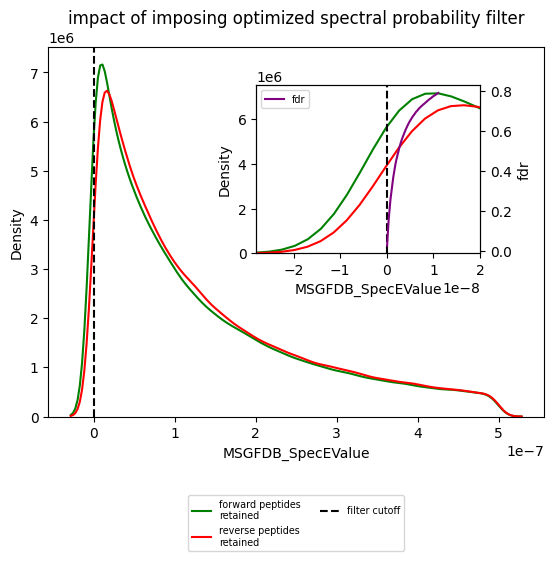

In [12]:
#initial guess at a log10 spectral probability filter value
initial_specprob_filter = -15

#perform optimization
optimization = agg_func.optimize_specFilt(initial_specprob_filter,forward_peptides,reversed_peptides)

#visualize optimization
optimization_fig = agg_func.visualize_optimization(optimization,forward_peptides,reversed_peptides)

del initial_specprob_filter

Apply the filter to the dataset and recalculate peptide and spectral FDR

In [13]:
#Filter the data according to the filter and recalculate FDR
forward_peptides = forward_peptides[
    (forward_peptides["MSGFDB_SpecEValue"] < 10 ** optimization.x[0])
].copy()

reversed_peptides = reversed_peptides[
    (reversed_peptides["MSGFDB_SpecEValue"] < 10 ** optimization.x[0])
].copy()

# Calculate FDR
f_spec = (forward_peptides["SpecID"].unique().size)
r_spec = reversed_peptides["SpecID"].unique().size
if (f_spec == 0) & (r_spec == 0):
    fdr_spec = 1
else:
    fdr_spec = (2*r_spec) / (f_spec + r_spec)

f_pep = forward_peptides["Peptide Sequence with Mods"].unique().size
r_pep = reversed_peptides["Peptide Sequence with Mods"].unique().size
if (f_pep == 0) & (r_pep == 0):
    fdr_pep = 1
else:
    fdr_pep = (r_pep) / (f_pep + r_pep)

del f_spec, r_spec, f_pep, r_pep

print("Spectral FDR:",fdr_spec,"\nPeptide FDR:",fdr_pep)


Spectral FDR: 0.04997791380071938 
Peptide FDR: 0.055613538094528105


## 3) Collapse to unique peptides and normalize quantification

Apply log2 transformation and median normalize the peptide abundances

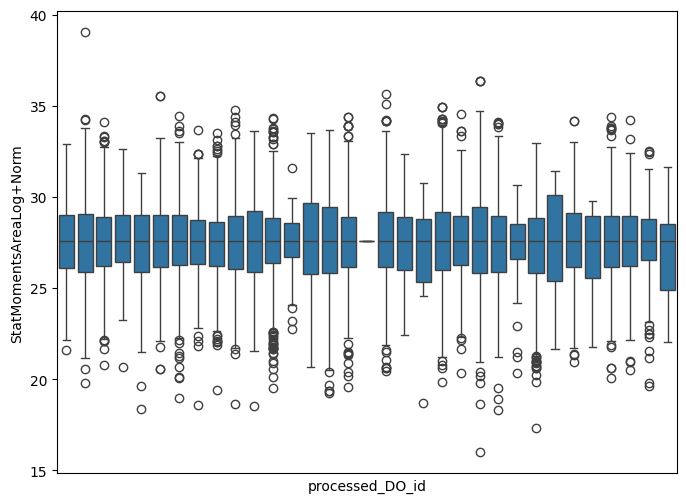

In [14]:
#extract data set id
forward_peptides['processed_DO_id'] = forward_peptides['SpecID'].str.split('_').str[0]

#log2 tranformation
forward_peptides['StatMomentsAreaLog2']=np.log2(forward_peptides['StatMomentsArea'])

# Calculate group-wise (sample wise) median
group_medians = forward_peptides.groupby('processed_DO_id')['StatMomentsAreaLog2'].median()

# Calculate data wide median
all_data_median=forward_peptides['StatMomentsAreaLog2'].median()

# Subtract sample wise median from each value within its group
forward_peptides['StatMomentsAreaLog+Norm'] = forward_peptides.apply(
    lambda row: row['StatMomentsAreaLog2'] - group_medians[row['processed_DO_id']], axis=1
)

#add back in a data wide median value to avoid negative abundances
forward_peptides['StatMomentsAreaLog+Norm'] = forward_peptides['StatMomentsAreaLog+Norm'] + all_data_median

transformed_abundances_fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(x='processed_DO_id',y='StatMomentsAreaLog+Norm',data=forward_peptides)
plt.xticks([])

del ax, group_medians, all_data_median, forward_peptides['StatMomentsArea'], forward_peptides['StatMomentsAreaLog2'], reversed_peptides

Sum abundances for peptide sequences that were detected more than once in a dataset, leaving a single abundance value for each peptide in each dataset

In [15]:
#drop SpecID and spectral probability columns since no longer relevant
forward_peptides.drop(['SpecID','MSGFDB_SpecEValue'],axis=1, inplace=True)

#for each peptide sequence with mods, sum the abundances for all scans/identifications
forward_peptides = forward_peptides.groupby(['processed_DO_id','Peptide Sequence with Mods'])['StatMomentsAreaLog+Norm'].sum().to_frame().reset_index()

display(forward_peptides)


,processed_DO_id,Peptide Sequence with Mods,StatMomentsAreaLog+Norm
0,nmdc:dobj-11-2k6s1505,AALAANSELMNK,27.600737
1,nmdc:dobj-11-2k6s1505,AFTVDEMR,26.634867
2,nmdc:dobj-11-2k6s1505,AGGSITSSGGVERNDVDYSAVLTK,23.278834
...,...,...,...
12100,nmdc:dobj-11-zn9eyg46,VAELEATTAR,60.339342
12101,nmdc:dobj-11-zn9eyg46,VAELEATTVR,27.188419
12102,nmdc:dobj-11-zn9eyg46,WLWNYYQYYK,22.022224


## 4) Generate protein mappings using both "Razor" and "Sorted List" strategies

Collect peptide to protein mapping information for the passsing peptide sequences and the gene annotation information for the related proteins

In [16]:
#get mapping info for FDR passing Peptide Sequence with Mods
peptide_protein_mapping = pd.DataFrame(unfilt_res[unfilt_res['Peptide Sequence with Mods'].isin(forward_peptides['Peptide Sequence with Mods'])][['Peptide Sequence with Mods','Protein']].drop_duplicates()).reset_index(drop=True)
peptide_protein_mapping

,Peptide Sequence with Mods,Protein
0,NLTTGPGSAQEAIFNR,nmdc:wfmgan-11-z0q72297.1_004752_2_691
1,TYTLRPGAVAEFEER,nmdc:wfmgan-11-z0q72297.1_013275_1_561
2,ELASSAAYTTIQTVK,nmdc:wfmgan-11-z0q72297.1_056571_1_339
...,...,...
20302,AHLDQIVTR,nmdc:wfmgan-11-z0raab34.1_002480_199_1413
20303,GEPNLENELWR,nmdc:wfmgan-11-z0raab34.1_005022_699_1082
20304,GEPNLENELWR,nmdc:wfmgan-11-z0raab34.1_024291_3_491


In [17]:
#get gene annotation information for proteins
gene_annotations = proteomics_processing_df[["processed_DO_id", "annotation_url"]].drop_duplicates().reset_index(drop=True)

gene_annotations = agg_func.tsv_extract(
    pd_df=gene_annotations,\
    identifier_col='processed_DO_id',\
    url_col='annotation_url',\
    extract_cols=[8],\
    header=None
)

#name gene annotation columns
gene_annotations = gene_annotations.set_axis(['gene_info','id_col'], axis=1)

# split the gene_info string into a dictionary and create new columns using title=value; as format
def split_to_dict(row):
    return dict(item.split('=') for item in row.split(';'))
gene_annotations = gene_annotations.loc[:,'gene_info'].apply(split_to_dict).apply(pd.Series)

#filter to proteins passing FDR filter
gene_annotations = gene_annotations[gene_annotations['ID'].isin(peptide_protein_mapping['Protein'].unique().tolist())]

#join with peptide to protein mapping info
mapping_annotations = gene_annotations.merge(peptide_protein_mapping,left_on='ID',right_on='Protein').drop('ID',axis=1)

#subset to product and product_source from gff
mapping_annotations = mapping_annotations[['product','product_source','Peptide Sequence with Mods','Protein']]

del peptide_protein_mapping, gene_annotations

mapping_annotations

/Users/ober845/Library/CloudStorage/OneDrive-PNNL/Desktop/nmdc_notebooks/proteomic_aggregation_and_visualization/python/aggregation_functions.py:64: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  tsv_df = pd.read_csv(tsv_data,sep='\t',header=header)
/Users/ober845/Library/CloudStorage/OneDrive-PNNL/Desktop/nmdc_notebooks/proteomic_aggregation_and_visualization/python/aggregation_functions.py:64: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  tsv_df = pd.read_csv(tsv_data,sep='\t',header=header)
/Users/ober845/Library/CloudStorage/OneDrive-PNNL/Desktop/nmdc_notebooks/proteomic_aggregation_and_visualization/python/aggregation_functions.py:64: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  tsv_df = pd.read_csv(tsv_data,sep='\t',header=header)
/Users/ober845/Library/CloudStorage/OneDrive-PNNL/Desktop/nmdc_notebooks/proteomic_ag

,product,product_source,Peptide Sequence with Mods,Protein
0,hypothetical protein,Hypo-rule applied,AMERGETYVNVHTEKNPNGEIR,nmdc:wfmgan-11-z0q72297.1_000027_1367_1870
1,carboxymethylenebutenolidase,KO:K01061,GVGHAFANPSGENYAPK,nmdc:wfmgan-11-z0q72297.1_000043_2237_3076
2,nitrite reductase (NO-forming),KO:K00368,LLSDNPDLVLTNGMAHK,nmdc:wfmgan-11-z0q72297.1_000048_1_840
...,...,...,...,...
20302,acetoacetate decarboxylase,COG4689,SPDGNTYYGGYYPYMYLTQDAAVFAGREPFGFPK,nmdc:wfmgan-11-z0raab34.1_167280_3_278
20303,basic membrane protein A and related proteins,KO:K07335,GFNEFSIAGFER,nmdc:wfmgan-11-z0raab34.1_167989_2_277
20304,basic membrane protein A and related proteins,KO:K07335,AQEELGVDGR,nmdc:wfmgan-11-z0raab34.1_167989_2_277


Perform razor protein mapping, which is a method of mapping degenerate peptides (i.e. peptides that map to more than one protein).

The rules are as follows:
- If a peptide is unique to a protein, then that is the razor
- If a peptide belongs to more than one protein, but one of those proteins has a unique peptide, then that protein is the razor
- If a peptide belongs to more than one protein and one of those proteins has has the maximal number of peptides, then that protein is the razor
- If a peptide belongs to more than one protein and more than one of those proteins has the maximal number of peptides, then collapse the proteins and gene annotations into single strings
- If a peptide belongs to more than one protein and more than one of those proteins has a unique peptide, then the peptide is removed from analysis because its mapping is inconclusive

In [19]:
razormapping = agg_func.razorprotein(mapping_annotations)
razormapping

,product,product_source,Peptide Sequence with Mods,razor
0,dodecin,KO:K09165,AAAAAIATASR,nmdc:wfmgan-11-j69wrb16.1_070513_62_277
1,dodecin,KO:K09165,AAAAAIETASR,nmdc:wfmgan-11-p3dkkz54.1_002072_639_854
2,"dodecin, dodecin, dodecin, dodecin, dodecin","KO:K09165, KO:K09165, KO:K09165, KO:K09165, KO...",AAAAAVETASR,"nmdc:wfmgan-11-6pq4bd13.1_044073_3_326, nmdc:w..."
...,...,...,...,...
5990,peptide/nickel transport system substrate-bind...,KO:K02035,YYQDHFGQYGKGDVAGAQK,nmdc:wfmgan-11-j69wrb16.1_013078_1_984
5991,YgiT-type zinc finger domain-containing protei...,"TIGR03831, Hypo-rule applied",YYSADTLK,"nmdc:wfmgan-11-21ms6426.1_119378_95_340, nmdc:..."
5992,uncharacterized protein,KO:K06996,YYSELFGWQVHEVMPTYGLVHTEAGGK,nmdc:wfmgan-11-v53k8v91.1_045759_189_458


Perform sorted list protein mapping, which is a method of mapping degenerate peptides we employ here in order to obtain a single protein identification for each peptide returned. This is not the same as the popularly used 'first hit' strategy although it employs as similar logic, because it doesn't depend on the original search fasta.

It's defined as:

- If a peptide is unique to a protein, then that is the sorted_list protein
- If a peptide belongs to more than one protein, but one of those proteins has a unique peptide, then that protein is the sorted_list protein
- If a peptide belongs to more than one protein and one of those proteins has has the maximal number of peptides, then that is the sorted_list protein
- If a peptide belongs to more than one protein and more than one of those proteins has the maximal number of peptides, then the sorted_list is the first protein in a sorted list of all proteins across datasets
- If a peptide belongs to more than one protein and more than one of those proteins has a unique peptide, then the peptide is removed from analysis because its mapping is inconclusive

In [20]:
sortedmapping = agg_func.sortedprotein(mapping_annotations)
sortedmapping

,product,product_source,Peptide Sequence with Mods,sorted_list_protein
0,dodecin,KO:K09165,AAAAAIATASR,nmdc:wfmgan-11-j69wrb16.1_070513_62_277
1,dodecin,KO:K09165,AAAAAIETASR,nmdc:wfmgan-11-p3dkkz54.1_002072_639_854
2,dodecin,KO:K09165,AAAAAVETASR,nmdc:wfmgan-11-6pq4bd13.1_044073_3_326
...,...,...,...,...
5990,peptide/nickel transport system substrate-bind...,KO:K02035,YYQDHFGQYGKGDVAGAQK,nmdc:wfmgan-11-j69wrb16.1_013078_1_984
5991,YgiT-type zinc finger domain-containing protein,TIGR03831,YYSADTLK,nmdc:wfmgan-11-21ms6426.1_119378_95_340
5992,uncharacterized protein,KO:K06996,YYSELFGWQVHEVMPTYGLVHTEAGGK,nmdc:wfmgan-11-v53k8v91.1_045759_189_458


## 5) Perform protein rollup using the "Sorted List" results and summarize into a final aggregated crosstab

Combine sortedmapping information with the quantification since sortedmapping returns a single protein for each peptide

In [21]:
#merge needs to be 'right' because some peptides are removed in mapping functions if they have indeterminante mappings
forward_peptides = forward_peptides.merge(sortedmapping,how='right',on=['Peptide Sequence with Mods'])
del razormapping, mapping_annotations, sortedmapping

forward_peptides

,processed_DO_id,Peptide Sequence with Mods,StatMomentsAreaLog+Norm,product,product_source,sorted_list_protein
0,nmdc:dobj-11-jqrf1211,AAAAAIATASR,30.109155,dodecin,KO:K09165,nmdc:wfmgan-11-j69wrb16.1_070513_62_277
1,nmdc:dobj-11-vjmd5h28,AAAAAIETASR,30.839413,dodecin,KO:K09165,nmdc:wfmgan-11-p3dkkz54.1_002072_639_854
2,nmdc:dobj-11-tk9hc081,AAAAAVETASR,29.549325,dodecin,KO:K09165,nmdc:wfmgan-11-6pq4bd13.1_044073_3_326
...,...,...,...,...,...,...
10574,nmdc:dobj-11-jqrf1211,YYQDHFGQYGKGDVAGAQK,54.896380,peptide/nickel transport system substrate-bind...,KO:K02035,nmdc:wfmgan-11-j69wrb16.1_013078_1_984
10575,nmdc:dobj-11-sx7cyr58,YYSADTLK,29.721791,YgiT-type zinc finger domain-containing protein,TIGR03831,nmdc:wfmgan-11-21ms6426.1_119378_95_340
10576,nmdc:dobj-11-7psagy79,YYSELFGWQVHEVMPTYGLVHTEAGGK,27.078081,uncharacterized protein,KO:K06996,nmdc:wfmgan-11-v53k8v91.1_045759_189_458


De-log the peptide abundances, sum the abundances for each sorted_list protein then relog transform the rolled up protein abundances

In [22]:
#de-log abundance
forward_peptides['StatMomentsAreaNorm']=2**forward_peptides['StatMomentsAreaLog+Norm']
forward_peptides.drop('StatMomentsAreaLog+Norm',axis=1,inplace=True)

#sum abundance for each sorted_list protein in each dataset
prot_info = forward_peptides.columns[~forward_peptides.columns.isin(['StatMomentsAreaNorm','Peptide Sequence with Mods'])].tolist()
protein_abundances = forward_peptides.groupby(prot_info)['StatMomentsAreaNorm'].sum().reset_index()

#re-log2 tranform abundance
protein_abundances['StatMomentsAreaLog+Norm']=np.log2(protein_abundances['StatMomentsAreaNorm'])
protein_abundances.drop('StatMomentsAreaNorm',axis=1,inplace=True)

del prot_info

protein_abundances

,processed_DO_id,product,product_source,sorted_list_protein,StatMomentsAreaLog+Norm
0,nmdc:dobj-11-2k6s1505,DNA-binding protein HU-beta,KO:K03530,nmdc:wfmgan-11-8zxjs882.1_040719_104_331,25.090841
1,nmdc:dobj-11-2k6s1505,DNA-binding transcriptional LysR family regulator,COG0583,nmdc:wfmgan-11-21ms6426.1_010178_1_894,26.235653
2,nmdc:dobj-11-2k6s1505,DNA-directed RNA polymerase subunit beta',KO:K03046,nmdc:wfmgan-11-yjeh0m30.1_003176_3_1979,26.945549
...,...,...,...,...,...
8029,nmdc:dobj-11-zn9eyg46,peptidoglycan/xylan/chitin deacetylase (PgdA/C...,COG0726,nmdc:wfmgan-11-6pq4bd13.1_001294_1_411,24.607688
8030,nmdc:dobj-11-zn9eyg46,photosystem II CP43 chlorophyll apoprotein,KO:K02705,nmdc:wfmgan-11-hyze3t58.1_07201_3_464,28.083196
8031,nmdc:dobj-11-zn9eyg46,predicted porin,COG3203,nmdc:wfmgan-11-hyze3t58.1_02099_286_783,28.625736


## Final aggregated proteomic crosstab

Reformat these results into a typical proteomic crosstab, where each row indicates a protein and each column indicates a sample/dataset. The values within the crosstab are log transformed, median normalized abundance values. This table or the longform version above can be used in further proteomic analyses

In [23]:
#pivot to crosstab
aggregated_proteomic_output = protein_abundances.pivot(index='sorted_list_protein',columns='processed_DO_id',values='StatMomentsAreaLog+Norm')
aggregated_proteomic_output.columns.name = None

aggregated_proteomic_output

,nmdc:dobj-11-2k6s1505,nmdc:dobj-11-2szyc560,nmdc:dobj-11-301yh759,nmdc:dobj-11-3378mg86,nmdc:dobj-11-3ak2bc31,nmdc:dobj-11-4bwzhs42,nmdc:dobj-11-7psagy79,nmdc:dobj-11-7r5yea49,nmdc:dobj-11-7x21d450,nmdc:dobj-11-bxyvx506,...,nmdc:dobj-11-vjmd5h28,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-x6srbx72,nmdc:dobj-11-xm1yjv87,nmdc:dobj-11-y2aefn18,nmdc:dobj-11-yrbs4v96,nmdc:dobj-11-z47wnf07,nmdc:dobj-11-z8hc0j30,nmdc:dobj-11-zhz66007,nmdc:dobj-11-zn9eyg46
sorted_list_protein,,,,,,,,,,,,,,,,,,,,,
nmdc:wfmgan-11-21ms6426.1_000036_702_1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nmdc:wfmgan-11-21ms6426.1_000053_3_563,NaN,NaN,NaN,NaN,NaN,NaN,111.54655,NaN,NaN,NaN,...,103.969350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nmdc:wfmgan-11-21ms6426.1_000057_4146_5369,NaN,31.321929,28.416203,28.786161,NaN,NaN,31.29260,NaN,NaN,55.20339,...,30.487015,26.597519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nmdc:wfmgan-11-z0raab34.1_148395_2_283,NaN,60.829026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nmdc:wfmgan-11-z0raab34.1_160266_3_278,NaN,27.827188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nmdc:wfmgan-11-z0raab34.1_167280_3_278,NaN,24.794214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 6) Find additional datasets across omics types in NMDC that share relevant KEGG IDs with this study

Add sample information to longform version of crosstab (protein_abundances)

In [24]:
protein_abundances = proteomics_processing_df[['processed_DO_id','depth.has_numeric_value']].merge(protein_abundances,how='right',on='processed_DO_id')
del proteomics_processing_df, unfilt_res, forward_peptides

protein_abundances

,processed_DO_id,depth.has_numeric_value,product,product_source,sorted_list_protein,StatMomentsAreaLog+Norm
0,nmdc:dobj-11-2k6s1505,0.4,DNA-binding protein HU-beta,KO:K03530,nmdc:wfmgan-11-8zxjs882.1_040719_104_331,25.090841
1,nmdc:dobj-11-2k6s1505,0.4,DNA-binding transcriptional LysR family regulator,COG0583,nmdc:wfmgan-11-21ms6426.1_010178_1_894,26.235653
2,nmdc:dobj-11-2k6s1505,0.4,DNA-directed RNA polymerase subunit beta',KO:K03046,nmdc:wfmgan-11-yjeh0m30.1_003176_3_1979,26.945549
...,...,...,...,...,...,...
8029,nmdc:dobj-11-zn9eyg46,0.0,peptidoglycan/xylan/chitin deacetylase (PgdA/C...,COG0726,nmdc:wfmgan-11-6pq4bd13.1_001294_1_411,24.607688
8030,nmdc:dobj-11-zn9eyg46,0.0,photosystem II CP43 chlorophyll apoprotein,KO:K02705,nmdc:wfmgan-11-hyze3t58.1_07201_3_464,28.083196
8031,nmdc:dobj-11-zn9eyg46,0.0,predicted porin,COG3203,nmdc:wfmgan-11-hyze3t58.1_02099_286_783,28.625736


Calculate average abundance (area under the curve) for proteins detected in samples collected at a depth of either 0.0 m or 0.5 m. Then calculate logfold change, zscore and pvalue. 

NOTE: This notebook is choosing to treat samples collected at the same depth as 'replicates' in order to demonstrate proteomic analyses, despite the fact that these samples also vary on parameters such as date of collection and location. Also please note that there are no missing value filters being applied to this dataset, something that is typically needed in metaproteomic analyses due to frequency of missing values. 

In [25]:
# Pivot dataframe into longform
protein_abundances_analysis = protein_abundances[protein_abundances['depth.has_numeric_value'].isin([0.0,0.5])].groupby(['depth.has_numeric_value','product','product_source','sorted_list_protein'])['StatMomentsAreaLog+Norm'].mean().to_frame('average_area')\
    .reset_index().pivot(index=['product','product_source','sorted_list_protein'],columns='depth.has_numeric_value',values='average_area')

protein_abundances_analysis.columns.name=None
protein_abundances_analysis.reset_index(inplace=True)

# Calculate log fold change values between the averages
protein_abundances_analysis['logfc'] = protein_abundances_analysis[0.5] - protein_abundances_analysis[0.0]
protein_abundances_analysis.dropna(inplace=True)
protein_abundances_analysis.reset_index(inplace=True,drop=True)

#Calculate zscores for these log fold change values
protein_abundances_analysis['zscore']=(protein_abundances_analysis['logfc']-protein_abundances_analysis['logfc'].mean())/protein_abundances_analysis['logfc'].std()

#equate zscores to pvalue
protein_abundances_analysis['pvalue']=stats.norm.sf(abs(protein_abundances_analysis['zscore']))

#report pathway if significance pvalue < 0.05 or 'insignificant' if not
protein_abundances_analysis['significant_pathway']=np.where((protein_abundances_analysis['pvalue'] < 0.05) & (protein_abundances_analysis['logfc'] > 0.5), protein_abundances_analysis['product'],
                                                     np.where((protein_abundances_analysis['pvalue'] < 0.05) & (protein_abundances_analysis['logfc'] < -0.5), protein_abundances_analysis['product'], 'insignificant'))

protein_abundances_analysis

,product,product_source,sorted_list_protein,0.0,0.5,logfc,zscore,pvalue,significant_pathway
0,ABC-type phosphate transport system substrate-...,COG0226,nmdc:wfmgan-11-21ms6426.1_009320_1_336,29.734512,27.713315,-2.021197,-0.109416,0.456436,insignificant
1,D-xylose transport system substrate-binding pr...,KO:K10543,nmdc:wfmgan-11-afrz5241.1_001664_3_983,30.783525,27.396418,-3.387107,-0.159690,0.436563,insignificant
2,D-xylose transport system substrate-binding pr...,KO:K10543,nmdc:wfmgan-11-z0raab34.1_051743_1_408,24.539978,27.376956,2.836978,0.069393,0.472338,insignificant
...,...,...,...,...,...,...,...,...,...
174,uncharacterized protein YpmS,COG4698,nmdc:wfmgan-11-6pq4bd13.1_017589_105_437,29.214654,28.057955,-1.156699,-0.077598,0.469074,insignificant
175,uncharacterized protein with GYD domain,COG4274,nmdc:wfmgan-11-j69wrb16.1_067100_2_277,28.336947,35.127600,6.790653,0.214911,0.414918,insignificant
176,xanthine dehydrogenase YagS FAD-binding subunit,KO:K11178,nmdc:wfmgan-11-9mdyy902.1_028718_2_460,28.221738,24.162211,-4.059528,-0.184439,0.426835,insignificant


Use a volcano plot to visualize how many proteins are significantly expressed and the magnitude of their fold change. By annotating the gene pathways to which these proteins belong, we can surmise some biological processes most affected by changes in sample depth.

Text(0, 0.5, '-log10(pvalue)')

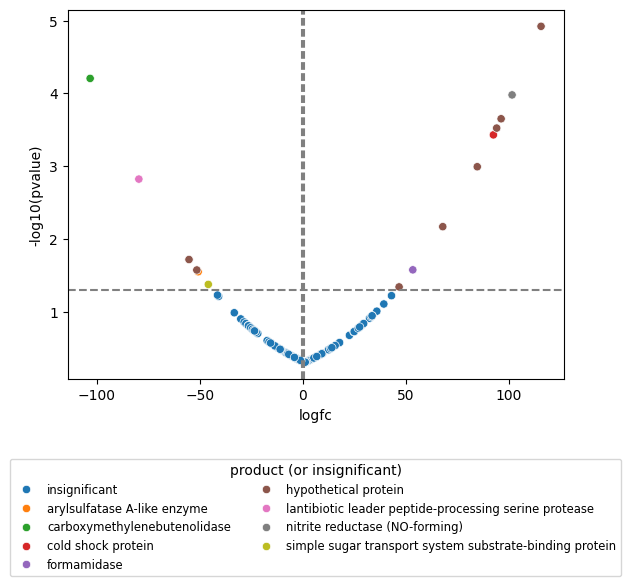

In [26]:
sns.scatterplot(x=protein_abundances_analysis['logfc'],y=-np.log10(protein_abundances_analysis['pvalue']),hue=protein_abundances_analysis['significant_pathway'])
plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--')
plt.axvline(x=-0.5, color='grey', linestyle='--')
plt.axvline(x=0.5, color='grey', linestyle='--')
plt.legend(title='product (or insignificant)',bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2,fontsize='small')
plt.ylabel('-log10(pvalue)')

Identify the gene pathways associated with the 5 largest log fold change values and search for other workflow output files in NMDC that have detected those KO pathways

In [27]:
#identify top 5 largest fold change values and their pathways
protein_abundances_analysis_top5 = protein_abundances_analysis[protein_abundances_analysis['significant_pathway']!='insignificant'].sort_values('logfc',key=abs,ascending=False).head(5).reset_index(drop=True)
protein_abundances_analysis_top5['gene_function_id']='KEGG.ORTHOLOGY:' + protein_abundances_analysis_top5['product_source'].str.split(':').str[1]

#find the workflow ids associated with each nonhypothetical pathway
KO_pathway_workflows = api_func.get_next_results(collection='functional_annotation_agg',\
                       filter='{"gene_function_id": {"$in": ["KEGG.ORTHOLOGY:K01061", "KEGG.ORTHOLOGY:K00368"]}}',\
                        max_page_size=100,fields='')

#find the workflow objects associated with these ids
workflow = api_func.get_id_results(newest_results=KO_pathway_workflows,\
                                id_field="was_generated_by",\
                                query_collection="workflow_execution_set",\
                                match_id_field="id",\
                                query_fields="has_input,has_output")

#find the different output files generated by these workflow objects
outputfiles=api_func.get_id_results(newest_results=workflow,\
                                id_field="has_output",\
                                query_collection="data_object_set",\
                                match_id_field="id",\
                                query_fields="id,data_object_type,url")

#combine information into dataframe
ko_references = pd.DataFrame(KO_pathway_workflows).merge(pd.DataFrame(workflow),left_on='was_generated_by',right_on='id').explode('has_output').drop(['has_input','id'],axis=1)\
    .merge(pd.DataFrame(outputfiles),left_on='has_output',right_on='id').\
        merge(protein_abundances_analysis_top5[['gene_function_id','product']].drop_duplicates(),on='gene_function_id',how='left')

del KO_pathway_workflows, workflow, outputfiles

#filter to a single result file for each potential omic type (proteomics, genomics, transcriptomics)
ko_references = ko_references[ko_references['data_object_type'].isin(['Unfiltered Metaproteomics Results', 'Annotation KEGG Orthology', 'Metatranscriptome Expression'])][['gene_function_id','product','count','id','data_object_type','url']]
display(ko_references)

,gene_function_id,product,count,id,data_object_type,url
0,KEGG.ORTHOLOGY:K01061,carboxymethylenebutenolidase,43,nmdc:dobj-11-m1bghr87,Annotation KEGG Orthology,https://data.microbiomedata.org/data/nmdc:ompr...
1,KEGG.ORTHOLOGY:K00368,nitrite reductase (NO-forming),3,nmdc:dobj-11-m1bghr87,Annotation KEGG Orthology,https://data.microbiomedata.org/data/nmdc:ompr...
44,KEGG.ORTHOLOGY:K01061,carboxymethylenebutenolidase,24,nmdc:dobj-11-bvge9w42,Annotation KEGG Orthology,https://data.microbiomedata.org/data/nmdc:ompr...
...,...,...,...,...,...,...
73016,KEGG.ORTHOLOGY:K01061,carboxymethylenebutenolidase,4,nmdc:dobj-11-72rprp25,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...
73020,KEGG.ORTHOLOGY:K01061,carboxymethylenebutenolidase,3,nmdc:dobj-11-5b9p4t76,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...
73024,KEGG.ORTHOLOGY:K01061,carboxymethylenebutenolidase,1,nmdc:dobj-11-qw8th334,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...


Determine how many proteomic ('Unfiltered Metaproteomics Results'), genomic ('Annotation KEGG Orthology') or transcriptomic ('Metatranscriptome Expression') results exist for each of these pathways in NMDC. This peeks into how the schema can be used to expand into multi-omic analyses.

Text(0.5, 0, 'result type')

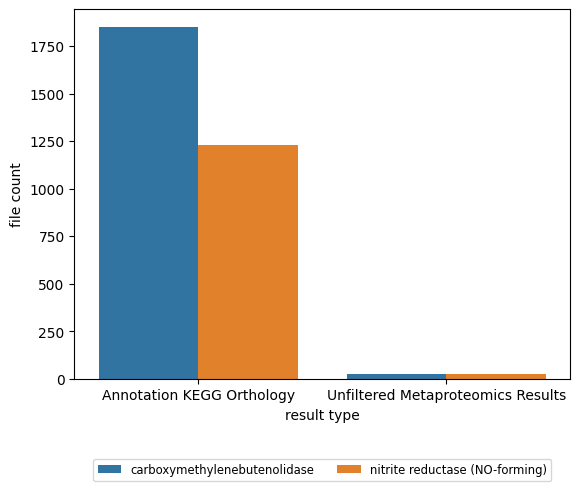

In [28]:
#count how many of these result files exist for each pathway
ko_references_count = ko_references[['product','data_object_type']].value_counts().to_frame().reset_index()

#graph
sns.barplot(data=ko_references_count,x='data_object_type',y='count',hue='product')
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2,fontsize='small')
plt.ylabel('file count')
plt.xlabel('result type')